In [603]:
# common imports
import zipfile, os, time, datetime, math, missingno, re
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import chain
from collections import Counter
from itertools import compress
from pytimekr import pytimekr
# from tensorflow.keras.preprocessing.text import Tokenizer
# from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
# from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

def date_feature_extraction(date_column, diff_date = None):
    """
    date_column : pandas series in timestamp format
    diff_date : "YYYY-MM-DD"
    """
    date = date_column
    time_df = pd.DataFrame()
    time_df['date'] = date
    time_df['year'] = date.dt.year # 연
    time_df['month'] = date.dt.month # 월
    time_df['day'] = date.dt.day # 일
    time_df['quarter'] = date.dt.quarter # 분기
    dow = {0:"mon",1:"tue",2:"wed",3:"thu",4:"fri",5:"sat",6:"sun"}
    time_df['dayofweek'] = pd.Series([dow[ii] for ii in date.dt.dayofweek]) # 요일

    holidays = []
    for i in range(date.min().year, date.max().year+1):
        holidays.extend(pytimekr.holidays(year=i))
    holidays = pd.to_datetime(pd.Series(holidays)).tolist()

    holidays_in_list = [ii for ii in date if ii.dayofweek in (5,6) or ii in holidays]  
    time_df['is_krweekend'] = date.isin(holidays_in_list) # 주말/휴일여부

    def season_finder(month_num):
        season_month = {'win':[12,1,2],'spr':[3,4,5],'sum':[6,7,8],'aut':[9,10,11]}
        return [k for k, v in season_month.items() if month_num in v][0]
    time_df['krseason'] = time_df['month'].map(season_finder) # 계절
    
    if diff_date != None:
        diff_dict = {"diff_day":"D","diff_week":"W","diff_month":"M","diff_quarter":"Q","diff_year":"Y"}
        for key, value in diff_dict.items():
            diff_dict.update({key:pd.to_datetime(diff_date).to_period(value)-date_column.dt.to_period(value)})
        time_df = pd.concat([time_df, pd.DataFrame(diff_dict, dtype=int)], axis=1)
    
    time_df.rename(
        columns=dict(zip(time_df.columns, [date.name+"_"+i for i in time_df.columns])), 
        inplace=True)
    return time_df

In [210]:
filedir = "./Datasets"
filenm = ["sample_BiddingData_Bundang_1901"]

for jj in filenm:
    data = zipfile.ZipFile(os.path.join(filedir, jj)+".zip")
    data.extract(jj+".xlsx", filedir)
    data.close()

In [211]:
df = pd.read_excel(os.path.join(filedir, filenm[0])+".xlsx", index_col="No.", dtype='str')
df = df.reset_index(drop=True)

# df.head(2).T
# df.describe(include='all')
# df.dtypes
# [re.sub('\n','',i) for i in df.columns]
# missingno.matrix(df)

In [212]:
# 고유값이 1개인 컬럼 제거
df = df.drop([column for column in df.columns if len(df[column].unique())==1], axis = 1)

## 변수 하나하나 살펴보기

In [213]:
# 0. 
# 딜러는 어떤 특징을 가지고 있을까?
# 주로 취급하는 차종/회사/기타기준 있을까?
# 어떤걸 보고 구매를 할까? 선택의 기준이 무엇일까?
# 가격예측은.... 예상 낙찰가를 예상하는 것일 가능성이 크다.(혹은 최소 금액 ~ 최대금액 바운더리?)
# 추천에는 딜러의 구매 이력도 봐야겟지만. 딜러가 구매하는것도 한계가 있으니 딜러의 버짓도 추정하면 좋겟다.
# 한개의 차를 여러 딜러에게 모두 추천하면 경쟁률이 너무 높아질 수 있겟다.... 고려할 필요는 없지 않나?
# 핫딜, 최신 등록차, 비딩 관심차, 리마켓팅으로 추정된 차량. 고스펙 차량, 추천 차량. 신차가격대비 고할인율 차량....조회!
# FDS 예제1 : https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services
# FDS 예제2 : https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now

In [214]:
# 1. 모델명
# df.모델명.str.split(' ')
display(df.모델명.unique()[:10])
# 특별한 규칙이 없다. 마스터 테이블 정보를 확보해서 맵핑하거나, NLP로 처리해야 할듯.
display(len(df.모델명.unique()))

array(['ALL_NEW_K7 2.2 디젤 프레스티지', 'ALL_NEW_K7 2.4 GDI 리미티드',
       'ALL_NEW_K7 2.4 GDI 프레스티지', 'ALL_NEW_K7 3.3 GDI 노블레스',
       'ALL_NEW_K7 3.3 GDI 노블레스 스페셜', 'ALL_NEW_크루즈 1.4 터보 LTZ',
       'Amazing_NEW_크루즈 1.8 가솔린 LT', 'BMW X4 XDrive 20d',
       'EQ900 3.3T-GDI PRESTIGE', 'EQ900 3.8GDI LUXURY'], dtype=object)

274

dtype('O')

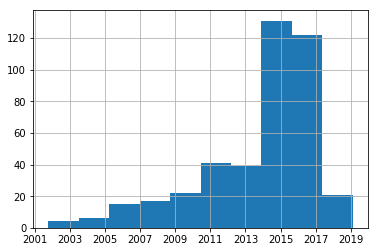

In [215]:
# 2. 최초등록일
display(df.최초등록일.dtype)
pd.to_datetime(df.최초등록일).hist()
# datetime형태로 변경해야함. 2001년 등록했는데 거즘 10년간 안팔린 매물도 극소량 있음. 2014년 매입 물량도 5년이 지난 시점에서 여전히 있음.
# 최초등록일이 과거일수록 저렴한 차일 가능성 있다. 
# 분포는 필연적으로 최근 날짜(우측)으로 치우쳐 있다.

In [216]:
# 최초등록일 feature group
df_dateinfo = date_feature_extraction(date_column=pd.to_datetime(df.최초등록일), diff_date=pytimekr.today())
df = pd.concat([df, df_dateinfo], axis=1)

dtype('O')

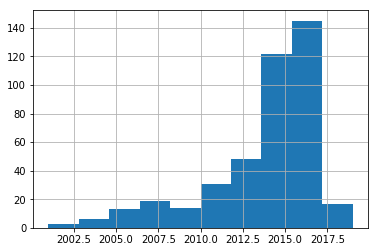

In [217]:
# 3. 연식
display(df.년식.dtype)
df.년식.astype(int).hist()
# 최초등록일과 매우 유사한 형태의 분포를 보임.
# 연식 특성상 최초 등록일보다 같거나 이전연도
# 분포는 필연적으로 최근 날짜(우측)으로 치우쳐 있다.

In [218]:
# 4. 미션
display(df.미션.dtype)
df.미션.value_counts()
# 오토가 95%정도 차지

dtype('O')

A/T    393
M/T     25
Name: 미션, dtype: int64

In [219]:
# 5. 연료
display(df.연료.dtype)
df.연료.value_counts()
# 가솔린, 디젤이 대부분 차지.

dtype('O')

가솔린       196
디젤        166
LPG        42
Hybrid     10
겸용          4
Name: 연료, dtype: int64

In [220]:
# 6. 색상
display(df.색상.dtype)
df.색상.value_counts()[:10]
# 기타색상이 많음. 차종과 연계해서 리뷰 필요.
# 구매여부에 영향을끼치는 변수인지도 확인 필요.
# 특정 색생이 대부분을 차지, 블랙/화이트/실버류

dtype('O')

기타             53
ABP)오로라블랙펄     27
TB7)팬텀블랙       24
SWP)스노우화이트펄    22
흰              20
UD)순백          14
YB6)오닉스블랙      14
3D)은빛실버        12
PGU)크리스탈화이트    11
P2S)하이퍼메탈릭     10
Name: 색상, dtype: int64

In [221]:
# 6.1 색상 카테고리 생성.
def sc_remover(text): # customized reg
    return re.sub('[-A-Z0-9km/*\n., ()]+', '', text)

color = df.색상.map(sc_remover)
color = pd.DataFrame(color)

color["b_color_dark"] = color['색상'].str.contains(
    "나이트|흑|블랙|검정|그레이|메탈|티타늄블랙|그라파이트|파인티타늄|다크"
)
color["b_color_white"] = color['색상'].str.contains("화이트|흰|순백")
color["b_color_silver"] = color['색상'].str.contains("실버|은|티타늄실버")
color["b_color_blue"] = color['색상'].str.contains("블루|아쿠아마린|청|오션")
color["b_color_other"] = color[[col for col in color.columns if 'color' in col]].sum(axis=1) !=1
color["b_color_unknown"] = color['색상'].str.contains("기타")

display(color.sum(axis=0))
display(color[color["b_color_other"]]['색상'].unique())
# df[df.색상.str.contains("청은")].head(1)

색상                 오로라블랙펄오로라블랙펄오로라블랙펄오로라블랙펄오로라블랙펄퓨어화이트기타흰오닉스블랙오닉스...
b_color_dark                                                     155
b_color_white                                                    113
b_color_silver                                                    63
b_color_blue                                                      26
b_color_other                                                     65
b_color_unknown                                                   53
dtype: object

array(['기타', '샌드트랙', '체리핑크', '밀키베이지', '자바브라운', '청은', '빨강', '실키브론즈'],
      dtype=object)

In [222]:
df = pd.concat([df, color], axis=1)

dtype('O')

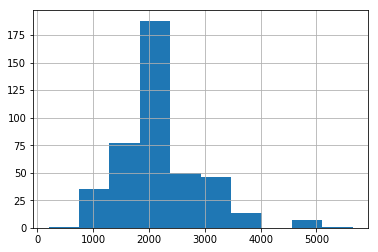

In [223]:
# 7. 배기량
display(df.배기량.dtype)
df.배기량.astype(int).hist()
# 정규분포띔. 2000이 중심.
# 차종과 연관있음.

dtype('O')

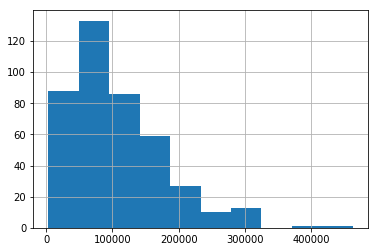

In [224]:
# 8. 주행거리
display(df.주행거리.dtype)
df.주행거리.astype(int).hist()
# int형태 또는 비닝 변환필요.
# 분포는 짧은거리쪽(좌측)으로 치우쳐 있다.

In [225]:
# 7. 용도
display(df.용도.dtype)
df.용도.value_counts()[:10]

dtype('O')

자가     196
렌트     155
업무      29
리스      29
nan      9
Name: 용도, dtype: int64

In [226]:
# 8. 소유
display(df.소유.dtype)
df.소유.value_counts()[:10]
# 소유/용도 크로스 체크 필요.

dtype('O')

법인상품    320
개인       53
법인       34
상품용      11
Name: 소유, dtype: int64

In [227]:
# 9. 평가등급
display(df['평가\n등급'].dtype)
df['평가\n등급'].value_counts()[:10]

dtype('O')

A    368
B     23
C     14
F      9
D      4
Name: 평가\n등급, dtype: int64

dtype('O')

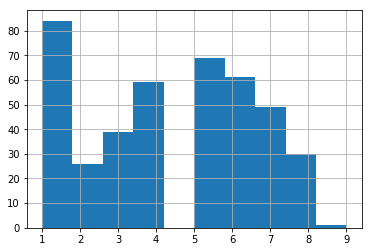

In [228]:
# 10. 평가점수
display(df['평가\n점수'].dtype)
df['평가\n점수'].astype(int).hist()
# 평가 등급/점수 크로스 체크 필요. 

In [229]:
# 11. 수출항목
display(df['수출\n항목'].dtype)
df['수출\n항목'].value_counts()[:10]
# 내수용이 압도적

dtype('O')

X    358
O     60
Name: 수출\n항목, dtype: int64

dtype('O')

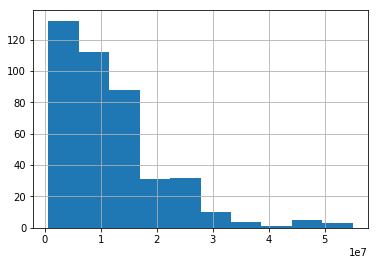

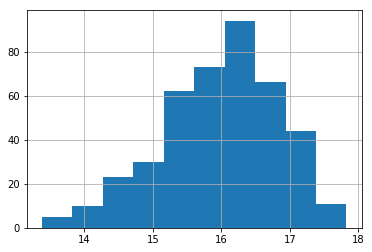

In [230]:
# 12. 낙찰가격
display(df.낙찰가격.dtype)
display(df.낙찰가격.astype(int).hist())
plt.show()
display(np.log(df.낙찰가격.astype(int)).hist())
plt.show()
# 2천만원 미만가격에 몰려있는 좌로 치우친 분포
# Y값이다. 로그변환을 할 필요가 있다.
# 최소값이 100만원.... 너무 극단적인 케이스는 제외 필요할듯.

In [231]:
# 13. 옵션
tmp = df.옵션.str.split(',')
display(tmp[:10])
Counter(list(chain.from_iterable(tmp)))
# 옵션 리스트. 멀티핫으로 표현해야 함. 단 시퀀스로서의 특징은 없음.

0             [ABS, AB2, VDC, 스마트키, 내비(일반)]
1             [ABS, AB2, VDC, 스마트키, 내비(일반)]
2             [ABS, AB2, VDC, 스마트키, 내비(일반)]
3             [ABS, AB2, VDC, 스마트키, 내비(일반)]
4             [ABS, AB2, VDC, 스마트키, 내비(일반)]
5    [ABS, AB2, TCS, 스마트키, 내비(일반), 썬루프(일반)]
6                           [ABS, AB2, TCS]
7    [ABS, AB2, TCS, 스마트키, 내비(일반), 썬루프(일반)]
8             [ABS, AB2, VDC, 스마트키, 내비(일반)]
9        [ABS, AB2, DIS, VDC, 스마트키, 내비(일반)]
Name: 옵션, dtype: object

Counter({'ABS': 386,
         'AB2': 354,
         'VDC': 279,
         '스마트키': 249,
         '내비(일반)': 179,
         'TCS': 26,
         '썬루프(일반)': 50,
         'DIS': 22,
         '내비게이션': 14,
         '썬루프': 6,
         '썬루프(파노라마)': 31,
         'AB1': 25,
         'ESP': 10,
         'nan': 18})

In [232]:
aa= []
for i in range(df.shape[0]):
    aa.append(df.옵션[i].replace("내비(일반)","내비게이션"))
    
bb= []
for i in range(len(aa)):
    bb.append(aa[i].replace("썬루프(일반)","썬루프"))
    
cc= []
for i in range(len(aa)):
    cc.append(bb[i].replace("썬루프(파노라마)","썬루프"))

In [233]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [234]:
options = mlb.fit_transform(pd.Series(cc).str.split(","))

In [235]:
df = pd.concat([df, pd.DataFrame(options, columns=["b_"+ i for i in mlb.classes_], dtype=bool)], axis=1)

In [702]:
# 특기사항 처리 1 : NLP 하여 데이터 구조화
def sc_remover(text): # customized reg
    return re.sub('[/*\n., ]+', '', text)

def custom_dictjoiner(dict1, dict2):
    for idx, val in enumerate({**dict1, **dict2}.keys()):
        try:
            ext1 = dict1[val]
        except:
            ext1 = []
        try:
            new1 = dict2[val]
        except:
            new1 = []
        if idx==0:
            result = {val:list(set(ext1+new1))}
        else:
            result.update({val:list(set(ext1+new1))})
    return result

def comment_categorization(data, category_list, initial_split):
    """
    pandas series data. i.e......
    0    필러트림/헤드라이닝/스탭몰딩불량, 엔진오일누유, 엔진/PS/터보이음, 실내오염
    1                              스텝몰딩불량, 엔진오일누유/이음
    """
    data_splited = data.str.split(initial_split)
    result = []
    for itemlist in data_splited:
        case_dict = {}
        for item in itemlist:
            item = item.replace("\n","")
            filtered_cate_list = list(compress(category_list, [i in item for i in category_list]))
            if len(filtered_cate_list) == 0:
                other_item = [i for i in [sc_remover(item.strip()).upper()] if len(i)>0]
                case_dict = custom_dictjoiner(dict1=case_dict,dict2={"기타":other_item})
            for _,j in enumerate(filtered_cate_list):
                item = item.replace(j,'')
            item = item.split('/')
            item = [sc_remover(i.strip()).upper() for i in item if len(i)>0]
            case_dict = custom_dictjoiner(dict1=case_dict,dict2={i:item for i in filtered_cate_list})
        result.append(case_dict)
    return result

In [703]:
comments = comment_categorization(
    data=df.특기사항, 
    category_list=[
        "판금","용접","불량","이음","누유","점등","오염","유격", 
        "교환","도장","심함","부조","부식","충격","꺾임","누수"], 
    initial_split=',')
## 구조화 결과 검수 필요
## 추후 테이블화해서 추가

# for i in comments:
#     try:
#         print(i['기타'])
#     except:
#         continue

In [707]:
comments[:10]

[{'불량': ['헤드라이닝', '필러트림', '스탭몰딩'],
  '누유': ['엔진오일'],
  '이음': ['PS', '엔진', '터보'],
  '오염': ['실내']},
 {'불량': ['스텝몰딩'], '이음': ['엔진오일'], '누유': ['엔진오일']},
 {'불량': ['스텝몰딩', '필러트림', '시트'],
  '이음': ['PS', '엔진오일'],
  '누유': ['엔진오일'],
  '판금': ['리어펜더(우)'],
  '용접': ['리어펜더(우)']},
 {'불량': ['헤드라이닝', 'PS'],
  '누유': ['엔진오일'],
  '이음': ['PS'],
  '유격': ['PS'],
  '심함': ['PS'],
  '오염': ['실내', '엔진룸'],
  '기타': ['뒷번호판볼트장착불가확인요']},
 {'점등': ['엔진', 'TPMS경고등']},
 {'불량': ['헤드라이닝']},
 {'이음': ['PS', '엔진']},
 {'기타': ['실차확인필클레임불가'],
  '불량': ['PS'],
  '누유': ['미션오일', '엔진'],
  '이음': ['엔진', '터보', '하체'],
  '부식': ['하체'],
  '교환': ['앞펜더(좌)'],
  '판금': ['리어펜더(우)', '리어펜더(좌)', '인사이드패널(좌)'],
  '용접': ['리어펜더(우)', '리어펜더(좌)', '인사이드패널(좌)']},
 {'불량': ['전동미러', '레이더센서'],
  '누유': ['미션오일', '엔진'],
  '이음': ['PS', '엔진'],
  '부조': ['엔진']},
 {'불량': ['스텝몰딩', '시트'], '이음': ['엔진오일'], '누유': ['엔진오일']}]

In [713]:
pd.DataFrame(comments).head()

교환               기타   꺾임   누수      누유   도장   부식   부조                   불량  \
0  NaN              NaN  NaN  NaN  [엔진오일]  NaN  NaN  NaN  [헤드라이닝, 필러트림, 스탭몰딩]   
1  NaN              NaN  NaN  NaN  [엔진오일]  NaN  NaN  NaN               [스텝몰딩]   
2  NaN              NaN  NaN  NaN  [엔진오일]  NaN  NaN  NaN     [스텝몰딩, 필러트림, 시트]   
3  NaN  [뒷번호판볼트장착불가확인요]  NaN  NaN  [엔진오일]  NaN  NaN  NaN          [헤드라이닝, PS]   
4  NaN              NaN  NaN  NaN     NaN  NaN  NaN  NaN                  NaN   

     심함         오염         용접    유격            이음             점등   충격  \
0   NaN       [실내]        NaN   NaN  [PS, 엔진, 터보]            NaN  NaN   
1   NaN        NaN        NaN   NaN        [엔진오일]            NaN  NaN   
2   NaN        NaN  [리어펜더(우)]   NaN    [PS, 엔진오일]            NaN  NaN   
3  [PS]  [실내, 엔진룸]        NaN  [PS]          [PS]            NaN  NaN   
4   NaN        NaN        NaN   NaN           NaN  [엔진, TPMS경고등]  NaN   

          판금  
0        NaN  
1        NaN  
2  [리어펜더(우)]  
3        NaN  
4        NaN

In [708]:
# 특기사항 처리 2 : NLP하지 않고 단순 텍스트의 길이로만 변수 생성
tmp2 = df.특기사항.str.replace('\n','')
tmp2 = tmp2.str.replace('*','')

tmp2 = tmp2.str.split(',')
display(tmp2[:10])
# Counter(list(chain.from_iterable(tmp2)))
# 점검 내용. NLP처리가 필요할듯.
# 특수기호, 쉼표등을 모두 제거한 상태에서 텍스트의 길이만으로도 유의미 할 것임.

0     [필러트림/헤드라이닝/스탭몰딩불량,  엔진오일누유,  엔진/PS/터보이음,  실내오염]
1                                 [스텝몰딩불량,  엔진오일누유/이음]
2    [시트/필러트림/스텝몰딩불량,  엔진오일누유/이음,  ps이음,  리어펜더(우)판금...
3    [PS/헤드라이닝불량,  엔진오일누유,  PS이음심함/유격,  엔진룸/실내오염,  ...
4                                       [엔진/TPMS경고등점등]
5                                            [헤드라이닝불량]
6                                            [엔진/PS이음]
7    [실차확인필/클레임불가,  PS불량,  엔진/미션오일누유,  엔진/터보/하체이음, ...
8          [레이더센서/전동미러불량,  엔진/미션오일누유,  엔진/PS이음,  엔진부조]
9                              [시트/스텝몰딩불량,  엔진오일누유/이음]
Name: 특기사항, dtype: object

In [709]:
def sc_remover(text): # customized reg
    return re.sub('[-0-9km/*\n., ()]+', '', text)

comment = df.특기사항.map(sc_remover)
df['comment_len'] = comment.apply(lambda x:len(x))

In [710]:
# 15. 상품번호
df.상품번호.unique()[:10]
# 고유값 pk

array(['1902A0525', '1902A0456', '1902A0539', '1901A1925', '1902A0328',
       '1902A0468', '1901A2146', '1902A0463', '1901A1614', '1902A0621'],
      dtype=object)

In [201]:
df.drop(['색상', '옵션', '특기사항','b_nan','상품번호'], axis=1, inplace=True)

In [202]:
df.rename(columns={'평가\n등급':"평가등급",'평가\n점수':"평가점수", '수출\n항목':"수출항목"}, inplace=True)

In [203]:
df['최초등록일'] = pd.to_datetime(df['최초등록일'])
df['배기량'] = df['배기량'].astype(int)
df['주행거리'] = df['주행거리'].astype(int)
df['수출항목'] = df['수출항목'].apply(lambda x:x=="O")
df['낙찰가격'] = df['낙찰가격'].astype(int)

In [204]:
df

모델명      최초등록일    년식   미션   연료   배기량  \
0              ALL_NEW_K7 2.2 디젤 프레스티지 2017-01-25  2017  A/T   디젤  2199   
1              ALL_NEW_K7 2.4 GDI 리미티드 2017-02-06  2017  A/T  가솔린  2359   
2             ALL_NEW_K7 2.4 GDI 프레스티지 2016-07-15  2016  A/T  가솔린  2359   
3              ALL_NEW_K7 3.3 GDI 노블레스 2016-05-25  2016  A/T  가솔린  3342   
4          ALL_NEW_K7 3.3 GDI 노블레스 스페셜 2016-12-19  2017  A/T  가솔린  3342   
5               ALL_NEW_크루즈 1.4 터보 LTZ 2017-03-15  2017  A/T  가솔린  1399   
6           Amazing_NEW_크루즈 1.8 가솔린 LT 2015-11-25  2016  A/T  가솔린  1796   
7                    BMW X4 XDrive 20d 2014-11-27  2015  A/T   디젤  1995   
8              EQ900 3.3T-GDI PRESTIGE 2016-07-19  2016  A/T  가솔린  3342   
9              EQ900 3.3T-GDI PRESTIGE 2017-01-04  2017  A/T  가솔린  3342   
10             EQ900 3.3T-GDI PRESTIGE 2016-02-23  2016  A/T  가솔린  3342   
11                 EQ900 3.8GDI LUXURY 2016-02-04  2016  A/T  가솔린  3778   
12               EQ900 5.0GDI PRESTIGE 2016-01-12  2016  A/T  가솔린  5038   
13               EQ900 5.0GDI PRESTIGE 2016-02-04  2016  A/T  가솔린  5038   
14               EQ900 5.0GDI PRESTIGE 2016-02-04  2016  A/T  가솔린  5038   
15               EQ900 5.0GDI PRESTIGE 2016-03-25  2016  A/T  가솔린  5038   
16           G70 3.3가솔린T스포츠 슈프림 H-TRAC 2017-11-27  2018  A/T  가솔린  3342   
17                      G80 3.3 Luxury 2017-10-25  2018  A/T  가솔린  3342   
18              G80 3.3 Premium Luxury 2017-04-14  2017  A/T  가솔린  3342   
19               G80 3.3T SPORT H-TRAC 2017-06-14  2018  A/T  가솔린  3342   
20                         JEEP 그랜드체로키 2004-01-30  2003  A/T  가솔린  4701   
21              K3 1.6 가솔린(4도어) Deluxe 2015-07-17  2015  A/T  가솔린  1591   
22              K3 1.6 가솔린(4도어) Luxury 2015-01-30  2015  A/T  가솔린  1591   
23                  K3 1.6 디젤 Prestige 2014-12-23  2015  A/T   디젤  1582   
24                   K5 2.0LPI 렌터카 디럭스 2012-04-05  2013  A/T  LPG  1999   
25                   K5 2.0LPI 렌터카 디럭스 2013-02-06  2013  A/T  LPG  1999   
26                   K5 2.0LPI 렌터카 스마트 2012-04-24  2013  A/T  LPG  1999   
27                   K5 2.0LPI 렌터카 스마트 2012-07-25  2013  A/T  LPG  1999   
28                       K5 2.0가솔린 럭셔리 2012-02-22  2012  A/T  가솔린  1998   
29                     K5 2.0가솔린 프레스티지 2012-05-29  2013  A/T  가솔린  1999   
..                                 ...        ...   ...  ...  ...   ...   
388                       토스카 L62.0 SX 2007-08-23  2007  A/T  가솔린  1993   
389                       토스카 L62.0 SX 2007-03-15  2007  A/T  가솔린  1993   
390                   투싼 2.0디젤(2WD) MX 2006-08-01  2006  A/T   디젤  1991   
391      투싼 ix 2.0 디젤(2WD) LX20 Luxury 2012-03-19  2012  A/T   디젤  1995   
392      투싼 ix 2.0 디젤(2WD) LX20 Luxury 2010-08-11  2011  A/T   디젤  1995   
393     투싼 ix 2.0 디젤(2WD) LX20 Premier 2012-10-18  2013  A/T   디젤  1995   
394  투싼 ix 2.0 디젤(2WD) LX20 Smart Pack 2012-09-14  2013  A/T   디젤  1995   
395       투싼 ix 2.0 디젤(2WD) X20 Luxury 2011-07-25  2012  A/T   디젤  1995   
396              티볼리 에어 1.6 디젤(2WD) IX 2016-07-01  2016  A/T   디젤  1597   
397                 포르테 1.6CVVT(가솔린) S 2010-02-05  2010  A/T  가솔린  1591   
398             포르테 1.6CVVT(가솔린) Si 블랙 2008-09-04  2009  A/T  가솔린  1591   
399                       포터Ⅱ 더블캡  초장축 2009-10-15  2010  M/T   디젤  2497   
400                            포터Ⅱ 슈퍼캡 2012-01-06  2012  M/T   디젤  2497   
401                      포터Ⅱ 슈퍼캡  내장탑차 2010-01-06  2009  M/T   디젤  2497   
402                      포터Ⅱ 슈퍼캡  냉동탑차 2016-04-20  2016  M/T   디젤  2497   
403                      포터Ⅱ 슈퍼캡  냉동탑차 2014-10-29  2015  A/T   디젤  2497   
404                       포터Ⅱ 슈퍼캡  윙바디 2013-01-16  2013  M/T   디젤  2497   
405                       포터Ⅱ 슈퍼캡  초장축 2010-09-27  2011  M/T   디젤  2497   
406                       포터Ⅱ 슈퍼캡  초장축 2011-08-03  2012  M/T   디젤  2497   
407                       포터Ⅱ 슈퍼캡  초장축 2011-04-21  2011  M/T   디젤  2497   
408                       포터Ⅱ 슈퍼캡  초장축 2009-11-06  2010  M/T   디젤  2497   
409                       포터Ⅱ 슈퍼캡  초장축 2016-02-02  2016  M/T

In [205]:
df.dtypes

모델명                           object
최초등록일                 datetime64[ns]
년식                            object
미션                            object
연료                            object
배기량                            int32
주행거리                           int32
용도                            object
소유                            object
평가등급                          object
평가점수                          object
수출항목                            bool
낙찰가격                           int32
최초등록일_date            datetime64[ns]
최초등록일_year                     int64
최초등록일_month                    int64
최초등록일_day                      int64
최초등록일_quarter                  int64
최초등록일_dayofweek               object
최초등록일_is_krweekend              bool
최초등록일_krseason                object
최초등록일_diff_day                 int32
최초등록일_diff_week                int32
최초등록일_diff_month               int32
최초등록일_diff_quarter             int32
최초등록일_diff_year                int32
b_color_dark                    bool
b

In [611]:
# 누락 갯수를 변수로 생성
df['missing_as_var'] = df.isnull().sum(axis=1)

In [206]:
# from sklearn.preprocessing import StandardScaler

# for i, j in zip(df.columns, df.dtypes):
#     if i == "낙찰가격":
#         continue
#     if j == "object":
#         tmp_df = pd.get_dummies(df[i], prefix=i, dtype=bool)
#         del df[i]
#         df = pd.concat([df, tmp_df], axis= 1)
#     elif j =="int32" or j =="int64":
#         ss = StandardScaler()
#         tmp_list = ss.fit_transform(df[i].values.reshape(-1,1)).reshape(-1)
#         del df[i]
#         df[i] = tmp_list
#     else:
#         continue

In [711]:
# pd.set_option('display.max_rows', 500)
df.shape

(418, 50)

In [ ]:
# 데이터가 너무 없다...

### wnd with keras

In [ ]:
# https://github.com/jrzaurin/Wide-and-Deep-Keras
# -*- coding: utf-8 -*-
# to run:
# python wide_and_deep_keras.py --method method --model_type model_type
# --train_data train_path --test_data test_path
# Examples:
# 1_. wide and deep model for logistic regression (defaults)
# python wide_and_deep_keras.py
# 2_. deep model for multiclass classification
# python wide_and_deep_keras.py --method multiclass --model_type deep

import numpy as np
import pandas as pd
import os
import argparse
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Input, concatenate, Embedding, Reshape
from keras.layers import Merge, Flatten, merge, Lambda, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2, l1_l2


def maybe_download(train_data,test_data):
    """if adult data "train.csv" and "test.csv" are not in your directory,
    download them.
    """

    COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
               "marital_status", "occupation", "relationship", "race", "gender",
               "capital_gain", "capital_loss", "hours_per_week", "native_country",
               "income_bracket"]

    if not os.path.exists(train_data):
        print "downloading training data..."
        df_train = pd.read_csv("http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.data",
            names=COLUMNS, skipinitialspace=True)
    else:
        df_train = pd.read_csv("train.csv")

    if not os.path.exists(test_data):
        print "downloading testing data..."
        df_test = pd.read_csv("http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.test",
            names=COLUMNS, skipinitialspace=True, skiprows=1)
    else:
        df_test = pd.read_csv("test.csv")

    return df_train, df_test


def cross_columns(x_cols):
    """simple helper to build the crossed columns in a pandas dataframe
    """
    crossed_columns = dict()
    colnames = ['_'.join(x_c) for x_c in x_cols]
    for cname, x_c in zip(colnames, x_cols):
        crossed_columns[cname] = x_c
    return crossed_columns


def val2idx(df, cols):
    """helper to index categorical columns before embeddings.
    """
    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()
    for k, v in val_types.iteritems():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.iteritems():
        df[k] = df[k].apply(lambda x: v[x])

    unique_vals = dict()
    for c in cols:
        unique_vals[c] = df[c].nunique()

    return df, unique_vals


def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x).todense())


def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)


def continous_input(name):
    inp = Input(shape=(1,), dtype='float32', name=name)
    return inp, Reshape((1, 1))(inp)


def wide(df_train, df_test, wide_cols, x_cols, target, model_type, method):
    """Run the wide (linear) model.
    Params:
    -------
    df_train, df_test: train and test datasets
    wide_cols   : columns to be used to fit the wide model
    x_cols      : columns to be "crossed"
    target      : the target feature
    model_type  : accepts "wide" and "wide_deep" (or anything that is not
    "wide"). If "wide_deep" the function will build and return the inputs
    but NOT run any model.
    method      : the fitting method. accepts regression, logistic and multiclass
    Returns:
    --------
    if "wide":
    print the results obtained on the test set in the terminal.
    if "wide_deep":
    X_train, y_train, X_test, y_test: the inputs required to build wide and deep
    """

    df_train['IS_TRAIN'] = 1
    df_test['IS_TRAIN'] = 0
    df_wide = pd.concat([df_train, df_test])

    # my understanding on how to replicate what layers.crossed_column does. One
    # can read here: https://www.tensorflow.org/tutorials/linear.
    crossed_columns_d = cross_columns(x_cols)
    categorical_columns = list(
        df_wide.select_dtypes(include=['object']).columns)

    wide_cols += crossed_columns_d.keys()

    for k, v in crossed_columns_d.iteritems():
        df_wide[k] = df_wide[v].apply(lambda x: '-'.join(x), axis=1)

    df_wide = df_wide[wide_cols + [target] + ['IS_TRAIN']]

    dummy_cols = [
        c for c in wide_cols if c in categorical_columns + crossed_columns_d.keys()]
    df_wide = pd.get_dummies(df_wide, columns=[x for x in dummy_cols])

    train = df_wide[df_wide.IS_TRAIN == 1].drop('IS_TRAIN', axis=1)
    test = df_wide[df_wide.IS_TRAIN == 0].drop('IS_TRAIN', axis=1)

    # make sure all columns are in the same order and life is easier
    cols = [target] + [c for c in train.columns if c != target]
    train = train[cols]
    test = test[cols]

    X_train = train.values[:, 1:]
    y_train = train.values[:, 0].reshape(-1, 1)
    X_test = test.values[:, 1:]
    y_test = test.values[:, 0].reshape(-1, 1)
    if method == 'multiclass':
        y_train = onehot(y_train)
        y_test = onehot(y_test)

    # Scaling
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.fit_transform(X_test)

    if model_type == 'wide':

        activation, loss, metrics = fit_param[method]
        # metrics parameter needs to be passed as a list or dict
        if metrics:
            metrics = [metrics]

        # simply connecting the features to an output layer
        wide_inp = Input(shape=(X_train.shape[1],), dtype='float32', name='wide_inp')
        w = Dense(y_train.shape[1], activation=activation)(wide_inp)
        wide = Model(wide_inp, w)
        wide.compile(Adam(0.01), loss=loss, metrics=metrics)
        wide.fit(X_train, y_train, nb_epoch=10, batch_size=64)
        results = wide.evaluate(X_test, y_test)

        print "\n", results

    else:

        return X_train, y_train, X_test, y_test


def deep(df_train, df_test, embedding_cols, cont_cols, target, model_type, method):
    """Run the deep model. Two layers of 100 and 50 neurons. In a decent,
    finished code these would be tunable.
    Params:
    -------
    df_train, df_test: train and test datasets
    embedding_cols: columns to be passed as embeddings
    cont_cols     : numerical columns to be combined with the embeddings
    target        : the target feature
    model_type    : accepts "deep" and "wide_deep" (or anything that is not
    "wide"). If "wide_deep" the function will build and returns the inputs
    but NOT run any model
    method        : the fitting method. accepts regression, logistic and multiclass
    Returns:
    --------
    if "deep":
    print the results obtained on the test set in the terminal.
    if "wide_deep":
    X_train, y_train, X_test, y_test: the inputs required to build wide and deep
    inp_embed, inp_layer: the embedding layers and the input tensors for Model()
    """

    df_train['IS_TRAIN'] = 1
    df_test['IS_TRAIN'] = 0
    df_deep = pd.concat([df_train, df_test])

    deep_cols = embedding_cols + cont_cols

    # I 'd say that adding numerical columns to embeddings can be done in two ways:
    # 1_. normalise the values in the dataframe and pass them to the network
    # 2_. add BatchNormalization() layer. (I am not entirely sure this is right)
    # I'd say option 1 is the correct one. 2 performs better, which does not say much, but...

    # 1_. Scaling in the dataframe
    # scaler = MinMaxScaler()
    # cont_df = df_deep[cont_cols]
    # cont_norm_df = pd.DataFrame(scaler.fit_transform(df_train[cont_cols]))
    # cont_norm_df.columns = cont_cols
    # for c in cont_cols: df_deep[c] = cont_norm_df[c]

    df_deep, unique_vals = val2idx(df_deep, embedding_cols)

    train = df_deep[df_deep.IS_TRAIN == 1].drop('IS_TRAIN', axis=1)
    test = df_deep[df_deep.IS_TRAIN == 0].drop('IS_TRAIN', axis=1)

    embeddings_tensors = []
    n_factors = 8
    reg = 1e-3
    for ec in embedding_cols:
        layer_name = ec + '_inp'
        t_inp, t_build = embedding_input(
            layer_name, unique_vals[ec], n_factors, reg)
        embeddings_tensors.append((t_inp, t_build))
        del(t_inp, t_build)

    continuous_tensors = []
    for cc in cont_cols:
        layer_name = cc + '_in'
        t_inp, t_build = continous_input(layer_name)
        continuous_tensors.append((t_inp, t_build))
        del(t_inp, t_build)

    X_train = [train[c] for c in deep_cols]
    y_train = np.array(train[target].values).reshape(-1, 1)
    X_test = [test[c] for c in deep_cols]
    y_test = np.array(test[target].values).reshape(-1, 1)

    if method == 'multiclass':
        y_train = onehot(y_train)
        y_test = onehot(y_test)

    inp_layer =  [et[0] for et in embeddings_tensors]
    inp_layer += [ct[0] for ct in continuous_tensors]
    inp_embed =  [et[1] for et in embeddings_tensors]
    inp_embed += [ct[1] for ct in continuous_tensors]

    if model_type == 'deep':

        activation, loss, metrics = fit_param[method]
        if metrics:
            metrics = [metrics]

        d = merge(inp_embed, mode='concat')
        d = Flatten()(d)
        # 2_. layer to normalise continous columns with the embeddings
        d = BatchNormalization()(d)
        d = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(d)
        # d = Dropout(0.5)(d) # Dropout don't seem to help in this model
        d = Dense(50, activation='relu')(d)
        # d = Dropout(0.5)(d) # Dropout don't seem to help in this model
        d = Dense(y_train.shape[1], activation=activation)(d)
        deep = Model(inp_layer, d)
        deep.compile(Adam(0.01), loss=loss, metrics=metrics)
        deep.fit(X_train, y_train, batch_size=64, nb_epoch=10)
        results = deep.evaluate(X_test, y_test)


        print "\n", results

    else:

        return X_train, y_train, X_test, y_test, inp_embed, inp_layer


def wide_deep(df_train, df_test, wide_cols, x_cols, embedding_cols, cont_cols, method):
    """Run the wide and deep model. Parameters are the same as those for the
    wide and deep functions
    """

    # Default model_type is "wide_deep"
    X_train_wide, y_train_wide, X_test_wide, y_test_wide = \
        wide(df_train, df_test, wide_cols, x_cols, target, model_type, method)

    X_train_deep, y_train_deep, X_test_deep, y_test_deep, deep_inp_embed, deep_inp_layer = \
        deep(df_train, df_test, embedding_cols,cont_cols, target, model_type, method)

    X_tr_wd = [X_train_wide] + X_train_deep
    Y_tr_wd = y_train_deep  # wide or deep is the same here
    X_te_wd = [X_test_wide] + X_test_deep
    Y_te_wd = y_test_deep  # wide or deep is the same here

    activation, loss, metrics = fit_param[method]
    if metrics: metrics = [metrics]

    # WIDE
    w = Input(shape=(X_train_wide.shape[1],), dtype='float32', name='wide')

    # DEEP: the output of the 50 neurons layer will be the deep-side input
    d = merge(deep_inp_embed, mode='concat')
    d = Flatten()(d)
    d = BatchNormalization()(d)
    d = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(d)
    d = Dense(50, activation='relu', name='deep')(d)

    # WIDE + DEEP
    wd_inp = concatenate([w, d])
    wd_out = Dense(Y_tr_wd.shape[1], activation=activation, name='wide_deep')(wd_inp)
    wide_deep = Model(inputs=[w] + deep_inp_layer, outputs=wd_out)
    wide_deep.compile(optimizer=Adam(lr=0.01), loss=loss, metrics=metrics)
    wide_deep.fit(X_tr_wd, Y_tr_wd, nb_epoch=10, batch_size=128)

    # Maybe you want to schedule a second search with lower learning rate
    # wide_deep.optimizer.lr = 0.0001
    # wide_deep.fit(X_tr_wd, Y_tr_wd, nb_epoch=10, batch_size=128)

    results = wide_deep.evaluate(X_te_wd, Y_te_wd)

    print "\n", results


if __name__ == '__main__':

    ap = argparse.ArgumentParser()
    ap.add_argument("--method", type=str, default="logistic",help="fitting method")
    ap.add_argument("--model_type", type=str, default="wide_deep",help="wide, deep or both")
    ap.add_argument("--train_data", type=str, default="train.csv")
    ap.add_argument("--test_data", type=str, default="test.csv")
    args = vars(ap.parse_args())
    method = args["method"]
    model_type = args['model_type']
    train_data = args['train_data']
    test_data = args['test_data']

    fit_param = dict()
    fit_param['logistic']   = ('sigmoid', 'binary_crossentropy', 'accuracy')
    fit_param['regression'] = (None, 'mse', None)
    fit_param['multiclass'] = ('softmax', 'categorical_crossentropy', 'accuracy')

    df_train, df_test = maybe_download(train_data, test_data)

    # Add a feature to illustrate the logistic regression example
    df_train['income_label'] = (
        df_train["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)
    df_test['income_label'] = (
        df_test["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

    # Add a feature to illustrate multiclass classification
    age_groups = [0, 25, 65, 90]
    age_labels = range(len(age_groups) - 1)
    df_train['age_group'] = pd.cut(
        df_train['age'], age_groups, labels=age_labels)
    df_test['age_group'] = pd.cut(
        df_test['age'], age_groups, labels=age_labels)

    # columns for wide model
    wide_cols = ['age','hours_per_week','education', 'relationship', 'workclass',
                 'occupation','native_country','gender']
    x_cols = (['education', 'occupation'], ['native_country', 'occupation'])

    # columns for deep model
    embedding_cols = ['education', 'relationship', 'workclass', 'occupation',
                      'native_country']
    cont_cols = ["age","hours_per_week"]

    # target for logistic
    target = 'income_label'

    # # A set-up for multiclass classification would be:
    # # change method to multiclass
    # wide_cols = ["gender", "native_country", "education", "occupation", "workclass",
    #              "relationship"]
    # x_cols = (['education', 'occupation'], ['native_country', 'occupation'])

    # # columns for deep model
    # embedding_cols = ['education', 'relationship', 'workclass', 'occupation',
    #                   'native_country']
    # cont_cols = ["hours_per_week"]

    # # target
    # target = 'age_group'

    if model_type == 'wide':
        wide(df_train, df_test, wide_cols, x_cols, target, model_type, method)
    elif model_type == 'deep':
        deep(df_train, df_test, embedding_cols, cont_cols, target, model_type, method)
    else:
        wide_deep(df_train, df_test, wide_cols, x_cols, embedding_cols, cont_cols, method)

### wnd with pytorch

In [ ]:
# https://github.com/sa757/Wide-and-Deep-PyTorch
# https://wingnim.tistory.com/32
# -*- coding: utf-8 -*-
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader


use_cuda = torch.cuda.is_available()


class MultipleOptimizer(object):
    """Helper to use multiple optimizers as one.
    Parameters:
    ----------
    opts: List
        List with the names of the optimizers to use
    """
    def __init__(self, opts):
        self.optimizers = opts

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()


class WideDeepLoader(Dataset):
    """Helper to facilitate loading the data to the pytorch models.
    Parameters:
    ----------
    data: namedtuple with 3 elements - (wide_input_data, deep_inp_data, target)
    """
    def __init__(self, data):

        self.X_wide = data.wide
        self.X_deep = data.deep
        self.Y = data.labels

    def __getitem__(self, idx):

        xw = self.X_wide[idx]
        xd = self.X_deep[idx]
        y  = self.Y[idx]

        return xw, xd, y

    def __len__(self):
        return len(self.Y)


class WideDeep(nn.Module):
    """ Wide and Deep model. As explained in Heng-Tze Cheng et al., 2016, the
    model taked the wide features and the deep features after being passed through
    the hidden layers and connects them to an output neuron. For details, please
    refer to the paper and the corresponding tutorial in the tensorflow site:
    https://www.tensorflow.org/tutorials/wide_and_deep
    Parameters:
    --------
    wide_dim: Int
        dim of the wide-side input tensor
    embeddings_input: Tuple.
        3-elements tuple with the embeddings "set-up" - (col_name,
        unique_values, embeddings dim)
    continuous_cols: List.
        list with the name of the continuum columns
    deep_column_idx: Dict
        dictionary where the keys are column names and the values their
        corresponding index in the deep-side input tensor
    hidden_layers: List
        list with the number of units per hidden layer
    encoding_dict: Dict
        dictionary with the label-encode mapping
    n_class: Int
        number of classes. Defaults to 1 if logistic or regression
    dropout: Float
    """

    def __init__(self,
                 wide_dim,
                 embeddings_input,
                 continuous_cols,
                 deep_column_idx,
                 hidden_layers,
                 dropout,
                 encoding_dict,
                 n_class):

        super(WideDeep, self).__init__()
        self.wide_dim = wide_dim
        self.deep_column_idx = deep_column_idx
        self.embeddings_input = embeddings_input
        self.continuous_cols = continuous_cols
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.encoding_dict = encoding_dict
        self.n_class = n_class

        # Build the embedding layers to be passed through the deep-side
        for col,val,dim in self.embeddings_input:
            setattr(self, 'emb_layer_'+col, nn.Embedding(val, dim))

        # Build the deep-side hidden layers with dropout if specified
        input_emb_dim = np.sum([emb[2] for emb in self.embeddings_input])
        self.linear_1 = nn.Linear(input_emb_dim+len(continuous_cols), self.hidden_layers[0])
        if self.dropout:
            self.linear_1_drop = nn.Dropout(self.dropout[0])
        for i,h in enumerate(self.hidden_layers[1:],1):
            setattr(self, 'linear_'+str(i+1), nn.Linear( self.hidden_layers[i-1], self.hidden_layers[i] ))
            if self.dropout:
                setattr(self, 'linear_'+str(i+1)+'_drop', nn.Dropout(self.dropout[i]))

        # Connect the wide- and dee-side of the model to the output neuron(s)
        self.output = nn.Linear(self.hidden_layers[-1]+self.wide_dim, self.n_class)


    @staticmethod
    def set_optimizer(model_params, optimizer, learning_rate, momentum=0.0):
        """
        Simple helper so we can set the optimizers with a string, which will
        be convenient later. Add more parameters if you need.
        """
        if optimizer == "Adam":
            return torch.optim.Adam(model_params, lr=learning_rate)
        if optimizer == "Adagrad":
            return torch.optim.Adam(model_params, lr=learning_rate)
        if optimizer == "RMSprop":
            return torch.optim.RMSprop(model_params, lr=learning_rate, momentum=momentum)
        if optimizer == "SGD":
            return torch.optim.SGD(model_params, lr=learning_rate, momentum=momentum)


    @staticmethod
    def set_method(method):
        """
        Simple helper so we can set the method with a string, which will
        be convenient later.
        """
        if method =='regression':
            return None, F.mse_loss
        if method =='logistic':
            return torch.sigmoid, F.binary_cross_entropy
        if method=='multiclass':
            return F.softmax, F.cross_entropy


    def compile(self, method="logistic", optimizer="Adam", learning_rate=0.001, momentum=0.0):
        """Wrapper to set the activation, loss and the optimizer.
        Parameters:
        ----------
        method: String
            'regression', 'logistic' or 'multiclass'
        optimizer: String or Dict
            if string one of the following: 'SGD', 'Adam', or 'RMSprop'
            if Dictionary must contain two elements for the wide and deep
            parts respectively with keys 'wide' and 'deep'. E.g.
            optimizer = {'wide: ['SGD', 0.001, 0.3]', 'deep':['Adam', 0.001]}
        """
        self.method = method
        self.activation, self.criterion = self.set_method(method)

        if type(optimizer) is dict:
            params = list(self.parameters())
            # last two sets of parameters are the weights and bias of the last
            # linear layer
            last_linear_weights = params[-2]
            # by construction, the weights from wide_dim "in advance"
            # correspond to the wide side and will use one optimizer
            wide_params = [nn.Parameter(last_linear_weights[:, -self.wide_dim:])]
            # The weights from the deep side and the bias will use the other
            # optimizer
            deep_weights = last_linear_weights[:, :-self.wide_dim]
            deep_params = params[:-2] + [nn.Parameter(deep_weights)] + [params[-1]]
            # Very inelegant, but will do for now
            if len(optimizer['wide'])>2:
                wide_opt = self.set_optimizer(wide_params, optimizer['wide'][0], optimizer['wide'][1], optimizer['wide'][2])
            else:
                wide_opt = self.set_optimizer(wide_params, optimizer['wide'][0], optimizer['wide'][1])
            if len(optimizer['deep'])>2:
                deep_opt = self.set_optimizer(deep_params, optimizer['deep'][0], optimizer['deep'][1], optimizer['deep'][2])
            else:
                deep_opt = self.set_optimizer(deep_params, optimizer['deep'][0], optimizer['deep'][1])
            self.optimizer = MultipleOptimizer([wide_opt, deep_opt])
        elif type(optimizer) is str:
            self.optimizer = self.set_optimizer(self.parameters(), optimizer, learning_rate, momentum)


    def forward(self, X_w, X_d):
        """Implementation of the forward pass.
        Parameters:
        ----------
        X_w (torch.tensor) : wide-side input tensor
        X_d (torch.tensor) : deep-side input tensor
        Returns:
        --------
        out (torch.tensor) : result of the output neuron(s)
        """
        # Deep Side
        emb = [getattr(self, 'emb_layer_'+col)(X_d[:,self.deep_column_idx[col]].long())
               for col,_,_ in self.embeddings_input]
        if self.continuous_cols:
            cont_idx = [self.deep_column_idx[col] for col in self.continuous_cols]
            cont = [X_d[:, cont_idx].float()]
            deep_inp = torch.cat(emb+cont, 1)
        else:
            deep_inp = torch.cat(emb, 1)

        x_deep = F.relu(self.linear_1(deep_inp))
        if self.dropout:
            x_deep = self.linear_1_drop(x_deep)
        for i in range(1,len(self.hidden_layers)):
            x_deep = F.relu( getattr(self, 'linear_'+str(i+1))(x_deep) )
            if self.dropout:
                x_deep = getattr(self, 'linear_'+str(i+1)+'_drop')(x_deep)

        # Deep + Wide sides
        wide_deep_input = torch.cat([x_deep, X_w.float()], 1)
        if not self.activation:
            out = self.output(wide_deep_input)
        else:
            if (self.activation==F.softmax):
                out = self.activation(self.output(wide_deep_input), dim=1)
            else:
                out = self.activation(self.output(wide_deep_input))

        return out


    def fit(self, dataset, n_epochs, batch_size):
        """Run the model for the training set at dataset.
        Parameters:
        ----------
        dataset (dict): dictionary with the training sets -
        X_wide_train, X_deep_train, target
        n_epochs (int)
        batch_size (int)
        """
        widedeep_dataset = WideDeepLoader(dataset)
        train_loader = torch.utils.data.DataLoader(dataset=widedeep_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True)

        # set the model in training mode
        net = self.train()
        for epoch in range(n_epochs):
            total=0
            correct=0
            for i, (X_wide, X_deep, target) in enumerate(train_loader):
                X_w = Variable(X_wide)
                X_d = Variable(X_deep)
                y = (Variable(target).float() if self.method != 'multiclass' else Variable(target))

                if use_cuda:
                    X_w, X_d, y = X_w.cuda(), X_d.cuda(), y.cuda()

                self.optimizer.zero_grad()
                y_pred =  net(X_w, X_d)
                if(self.criterion == F.cross_entropy):
                    loss = self.criterion(y_pred, y) #[batch_size, 1]
                else:
                    loss = self.criterion(y_pred, y.view(-1, 1)) #[batch_size, 1]
                loss.backward()
                self.optimizer.step()

                if self.method != "regression":
                    total+= y.size(0)
                    if self.method == 'logistic':
                        y_pred_cat = (y_pred > 0.5).squeeze(1).float()
                    if self.method == "multiclass":
                        _, y_pred_cat = torch.max(y_pred, 1)
                    correct+= float((y_pred_cat == y).sum().item())

            if self.method != "regression":
                print ('Epoch {} of {}, Loss: {}, accuracy: {}'.format(epoch+1,
                    n_epochs, round(loss.item(),3), round(correct/total,4)))
            else:
                print ('Epoch {} of {}, Loss: {}'.format(epoch+1, n_epochs,
                    round(loss.item(),3)))


    def predict(self, dataset):
        """Predict target for dataset.
        Parameters:
        ----------
        dataset (dict): dictionary with the testing dataset -
        X_wide_test, X_deep_test, target
        Returns:
        --------
        array-like with the target for dataset
        """

        X_w = Variable(torch.from_numpy(dataset.wide)).float()
        X_d = Variable(torch.from_numpy(dataset.deep))

        if use_cuda:
            X_w, X_d = X_w.cuda(), X_d.cuda()

        # set the model in evaluation mode so dropout is not applied
        net = self.eval()
        pred = net(X_w,X_d).cpu()
        if self.method == "regression":
            return pred.squeeze(1).data.numpy()
        if self.method == "logistic":
            return (pred > 0.5).squeeze(1).data.numpy()
        if self.method == "multiclass":
            _, pred_cat = torch.max(pred, 1)
            return pred_cat.data.numpy()


    def predict_proba(self, dataset):
        """Predict predict probability for dataset.
        This method will only work with method logistic/multiclass
        Parameters:
        ----------
        dataset (dict): dictionary with the testing dataset -
        X_wide_test, X_deep_test, target
        Returns:
        --------
        array-like with the probability for dataset.
        """

        X_w = Variable(torch.from_numpy(dataset.wide)).float()
        X_d = Variable(torch.from_numpy(dataset.deep))

        if use_cuda:
            X_w, X_d = X_w.cuda(), X_d.cuda()

        # set the model in evaluation mode so dropout is not applied
        net = self.eval()
        pred = net(X_w,X_d).cpu()
        if self.method == "logistic":
            pred = pred.squeeze(1).data.numpy()
            probs = np.zeros([pred.shape[0],2])
            probs[:,0] = 1-pred
            probs[:,1] = pred
            return probs
        if self.method == "multiclass":
            return pred.data.numpy()


    def get_embeddings(self, col_name):
        """Extract the embeddings for the embedding columns.
        Parameters:
        -----------
        col_name (str) : column we want the embedding for
        Returns:
        --------
        embeddings_dict (dict): dictionary with the column values and the embeddings
        """

        params = list(self.named_parameters())
        emb_layers = [p for p in params if 'emb_layer' in p[0]]
        emb_layer  = [layer for layer in emb_layers if col_name in layer[0]][0]
        embeddings = emb_layer[1].cpu().data.numpy()
        col_label_encoding = self.encoding_dict[col_name]
        inv_dict = {v:k for k,v in col_label_encoding.items()}
        embeddings_dict = {}
        for idx,value in inv_dict.items():
            embeddings_dict[value] = embeddings[idx]

        return embeddings_dict

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
from collections import namedtuple
from itertools import chain
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


pd.options.mode.chained_assignment = None


def label_encode(df, cols=None):
    """
    Helper function to label-encode some features of a given dataset.
    Parameters:
    --------
    df  (pd.Dataframe)
    cols (list): optional - columns to be label-encoded
    Returns:
    ________
    val_to_idx (dict) : Dictionary of dictionaries with useful information about
    the encoding mapping
    df (pd.Dataframe): mutated df with Label-encoded features.
    """

    if cols == None:
        cols = list(df.select_dtypes(include=['object']).columns)

    val_types = dict()
    for c in cols:
        val_types[c] = df[c].unique()

    val_to_idx = dict()
    for k, v in val_types.items():
        val_to_idx[k] = {o: i for i, o in enumerate(val_types[k])}

    for k, v in val_to_idx.items():
        df[k] = df[k].apply(lambda x: v[x])

    return val_to_idx, df


def prepare_data(df, wide_cols, crossed_cols, embeddings_cols, continuous_cols, target,
    scale=False, def_dim=8, seed=1981):

    """Prepares a pandas dataframe for the WideDeep model.
    Parameters:
    ----------
    df (pd.Dataframe)
    wide_cols : list with the columns to be used for the wide-side of the model
    crossed_cols : list of tuples with the columns to be crossed
    embeddings_cols : this can be a list of column names or a list of tuples with
    2 elements: (col_name, embedding dimension for this column)
    continuous_cols : list with the continous column names
    target (str) : the target to be fitted
    scale (bool) : boolean indicating if the continuous columns must be scaled
    def_dim (int) : Default dimension of the embeddings. If no embedding dimension is
    included in the "embeddings_cols" input all embedding columns will use this value (8)
    seed (int) : Random State for the train/test split
    Returns:
    ----------
    wd_dataset (dict): dict with:
    train_dataset/test_dataset: tuples with the wide, deep and lable training and
    testing datasets
    encoding_dict : dict with useful information about the encoding of the features.
    For example, given a feature 'education' and a value for that feature 'Doctorate'
    encoding_dict['education']['Doctorate'] will return an the encoded integer.
    embeddings_input : list of tuples with the embeddings info per column:
    ('col_name', number of unique values, embedding dimension)
    deep_column_idx : dict with the column indexes of all columns considerd in the Deep-Side
    of the model
    """

    # If embeddings_cols does not include the embeddings dimensions it will be set as
    # def_dim
    if type(embeddings_cols[0]) is tuple:
        emb_dim = dict(embeddings_cols)
        embeddings_cols = [emb[0] for emb in embeddings_cols]
    else:
        emb_dim = {e:def_dim for e in embeddings_cols}
    deep_cols = embeddings_cols+continuous_cols

    # Extract the target and copy the dataframe so we don't mutate it
    # internally.
    Y = np.array(df[target])
    all_columns = list(set(wide_cols + deep_cols + list(chain(*crossed_cols))))
    df_tmp = df.copy()[all_columns]

    # Build the crossed columns
    crossed_columns = []
    for cols in crossed_cols:
        colname = '_'.join(cols)
        df_tmp[colname] = df_tmp[cols].apply(lambda x: '-'.join(x), axis=1)
        crossed_columns.append(colname)

    # Extract the categorical column names that can be one hot encoded later
    categorical_columns = list(df_tmp.select_dtypes(include=['object']).columns)

    # Encode the dataframe and get the encoding Dictionary only for the
    # deep_cols (for the wide_cols is uneccessary)
    encoding_dict,df_tmp = label_encode(df_tmp)
    encoding_dict = {k:encoding_dict[k] for k in encoding_dict if k in deep_cols}
    embeddings_input = []
    for k,v in encoding_dict.items():
        embeddings_input.append((k, len(v), emb_dim[k]))

    # select the deep_cols and get the column index that will be use later
    # to slice the tensors
    df_deep = df_tmp[deep_cols].copy()
    deep_column_idx = {k:v for v,k in enumerate(df_deep.columns)}

    # The continous columns will be concatenated with the embeddings, so you
    # probably want to normalize them first
    if scale:
        scaler = StandardScaler()
        for cc in continuous_cols:
            df_deep[cc]  = scaler.fit_transform(df_deep[cc].values.reshape(-1,1).astype(float))

    # select the wide_cols and one-hot encode those that are categorical
    df_wide = df_tmp[wide_cols+crossed_columns]
    del(df_tmp)
    dummy_cols = [c for c in wide_cols+crossed_columns if c in categorical_columns]
    df_wide = pd.get_dummies(df_wide, columns=dummy_cols)

    # train/test split
    X_train_deep, X_test_deep = train_test_split(df_deep.values, test_size=0.3, random_state=seed)
    X_train_wide, X_test_wide = train_test_split(df_wide.values, test_size=0.3, random_state=seed)
    y_train, y_test = train_test_split(Y, test_size=0.3, random_state=1981)

    # Building the output dictionary
    wd_dataset = dict()
    train_dataset = namedtuple('train_dataset', 'wide, deep, labels')
    test_dataset  = namedtuple('test_dataset' , 'wide, deep, labels')
    wd_dataset['train_dataset'] = train_dataset(X_train_wide, X_train_deep, y_train)
    wd_dataset['test_dataset']  = test_dataset(X_test_wide, X_test_deep, y_test)
    wd_dataset['embeddings_input']  = embeddings_input
    wd_dataset['deep_column_idx'] = deep_column_idx
    wd_dataset['encoding_dict'] = encoding_dict

    return wd_dataset

In [ ]:
from __future__ import print_function
import os
import torch
import numpy as np
import pandas as pd
# from wide_deep.torch_model import WideDeep
# from wide_deep.data_utils import prepare_data


use_cuda = torch.cuda.is_available()

DF = pd.read_csv('./Datasets/adult_data.csv')
DF['income_label'] = (DF["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

In [ ]:
# Experiment set up
wide_cols = ['age','hours_per_week','education', 'relationship','workclass',
             'occupation','native_country','gender']
crossed_cols = (['education', 'occupation'], ['native_country', 'occupation'])
embeddings_cols = [('education',10), ('relationship',8), ('workclass',10),
                    ('occupation',10),('native_country',10)]
continuous_cols = ["age","hours_per_week"]
target = 'income_label'
method = 'logistic'

In [ ]:
# Prepare data
wd_dataset = prepare_data(
    DF, wide_cols,
    crossed_cols,
    embeddings_cols,
    continuous_cols,
    target,
    scale=True)

In [ ]:
# Network set up
wide_dim = wd_dataset['train_dataset'].wide.shape[1]
n_unique = len(np.unique(wd_dataset['train_dataset'].labels))
if (method=="regression") or (method=="logistic"):
    n_class = 1
else:
    n_class = n_unique
deep_column_idx = wd_dataset['deep_column_idx']
embeddings_input= wd_dataset['embeddings_input']
encoding_dict   = wd_dataset['encoding_dict']
hidden_layers = [100,50]
dropout = [0.5,0.2]

In [ ]:
model = WideDeep(
    wide_dim,
    embeddings_input,
    continuous_cols,
    deep_column_idx,
    hidden_layers,
    dropout,
    encoding_dict,
    n_class)

In [ ]:
# if multiple compilers for wide and deep side:
# optimizer={'wide': ['name', lr, momentum], 'deep': ['name', lr, momentum]}
# for example:
# optimizer={'wide': ['SGD', 0.001, 0.1], 'deep': ['Adam', 0.001]}
# and
# model.compile(method=method, optimizer=optimizer)
model.compile(method=method)
if use_cuda:
    model = model.cuda()

In [ ]:
train_dataset = wd_dataset['train_dataset']
model.fit(dataset=train_dataset, n_epochs=10, batch_size=64)

test_dataset  = wd_dataset['test_dataset']
print(model.predict(dataset=test_dataset)[:10])
print(model.predict_proba(dataset=test_dataset)[:10])
print(model.get_embeddings('education'))

In [ ]:
# save
# MODEL_DIR = 'model'
# if not os.path.exists(MODEL_DIR):
#     os.makedirs(MODEL_DIR)
# torch.save(model.state_dict(), os.path.join(MODEL_DIR,'logistic.pkl'))

# load model
# model = WideDeep(
#     wide_dim,
#     embeddings_input,
#     continuous_cols,
#     deep_column_idx,
#     hidden_layers,
#     dropout,
#     encoding_dict,
#     n_class)
# model.compile(method=method)
# model.load_state_dict(torch.load('model/logistic.pkl'))

### MLP pytorch

In [ ]:
# https://9bow.github.io/PyTorch-tutorials-kr-0.3.1/index.html#
# -*- coding: utf-8 -*-
import torch
from torch.autograd import Variable

df = DF.copy()
del df['income_bracket']
df.head()

In [ ]:
# gender는 0,1으로 나머지는 scaling, one_hot

In [ ]:
continuous_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week']
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'native_country']
boolin_cols = ['gender']
label = 'income_label'

In [ ]:
for column in df.columns:
    if column in continuous_cols:
        scaled = StandardScaler().fit_transform(df[column].values.reshape(-1,1).astype(float))
        df[column] = scaled.reshape(-1)
    elif column in categorical_cols:
        onehot = pd.get_dummies(df[column], prefix=column)
        del df[column]
        df = pd.concat([df, onehot], axis=1)
    elif column in boolin_cols:
        df[column] = df[column].apply(lambda x:x=='Male')
    else:
        continue

In [ ]:
display(df.shape)
display(df.head())

In [ ]:
N, D_in, H, D_out = 48842, df.shape[1]-1, 1000, 1

In [ ]:
x = Variable(torch.from_numpy(df.drop('income_label', axis=1).astype('float').values)).float()
y = Variable(torch.from_numpy(df['income_label'].astype('int').values), requires_grad = False).float()

In [ ]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        print(1)

    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        print(2)
        return y_pred
    
model = TwoLayerNet(D_in, H, D_out)

In [ ]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
for t in range(500):
    y_pred = model(x)

    loss = criterion(y_pred, y)
#     loss = torch.nn.functional.binary_cross_entropy_with_logits(y_pred, y, reduction='sum')
    print(loss)
    print(t, loss.data[0])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
y_pred